<h1>Importações Necessárias:<h1>




In [ ]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.cluster import KMeans
from PIL import Image, ImageOps
from torchvision.io import read_image 
from torchvision.io import write_jpeg
import matplotlib.pyplot as plt
import math

In [ ]:
#Constantes
transform = transforms.Compose([
transforms.ToTensor(),transforms.Normalize(mean=0.5, std=0.5)])
batch_size = 4
num_workers = 1
base_path='/content/drive/MyDrive/Rede Neural/'
qtd_fotos={"Treino":[45,45,45,44,45,45,45,39,45,45],
                  "Testes":[15,15,15,18,30,17,15,27,15,15]}
inicio="LR_"
treino="Treino_Sampaio_Matsumoto/"
teste="Testes_Sampaio_Matsumoto/"
ha_arrumar="Ha_Arrumar/"
arrumado="Arrumados/"
altura=128
largura=72
input_size = altura*largura*3
hidden_size = 100000
output_size = 10

In [ ]:
def resize(x,y,treinamento):
  '''
  (int,int)->None
  Esta função é responsável por dar Resize nas imagens dos algarismos de x a y(inclusivo) de 
  AxBp para 28x28p para garantir que a rede neural não fique pesada demais
  '''
  if treinamento:
    tipo_bd=treino
  else:
    tipo_bd=teste
  for j in range(x,y+1):
    for i in range(qtd_fotos[tipo_bd[:6]][j]):
      path=base_path+tipo_bd+inicio+str(j)+"/"+str(j)+str(i+1)+".jpg"
      image = Image.open(path).convert('L')
      new_image = ImageOps.flip(image)
      new_image = new_image.resize((28, 28)).rotate(90)
      
      new_image.save(base_path+tipo_bd+ha_arrumar+str(j)+str(i+1)+".jpg")
    

In [ ]:
def to_black(x,y,treinamento):
  tipo_bd=teste
  if treinamento:
    tipo_bd=treino
  for j in range(x,y+1):
    for i in range(qtd_fotos[tipo_bd[:6]][j]):
      val = read_image(base_path+tipo_bd+ha_arrumar+str(j)+str(i+1)+".jpg")
      for x in range(val.shape[0]):
        for k in range(val.shape[1]):
          for h in range(val.shape[2]):
            if(val[x][k][h]>con):
              val[x][k][h]=255
            else:
              val[x][k][h]=0
      
      
      write_jpeg(val,base_path+tipo_bd+arrumado+str(j)+str(i+1)+".jpg")

In [ ]:
print(sum(qtd_fotos[teste[:6]]))

182


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load train data
trainset = torchvision.datasets.EMNIST(root='./data', train=True,
                                       download=True, transform=transform,split="digits")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, collate_fn=torch.utils.data.default_collate)

# load test data
testset = torchvision.datasets.EMNIST(root='./data', train=False,
                                       download=True, transform=transform,split="digits")
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('0','1', '2', '3', '4',
           '5', '6', '7', '8', '9')
print(trainloader)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


torch.Size([4, 1, 28, 28])


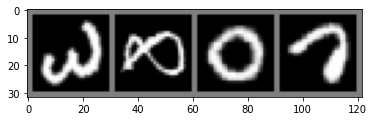

3 8 0 6


In [ ]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
  ''' Models a simple Convolutional Neural Network'''
  def __init__(self): 
    ''' initialize the network '''
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 
    # 3x3 square convolution kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    # Max pooling over a (2, 2) window
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(4*8*8, 120)# 5x5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    ''' the forward propagation algorithm '''
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 4*8*8)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
acuracias=[]
milissegundos=[]
correct=0
total=0
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        # print statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        if i%2000==0:
          # print every 2000 mini-batches
          end.record()
          torch.cuda.synchronize()
          acuracias.append(start.elapsed_time(end))
          milissegundos.append(correct/total)
          end=torch.cuda.Event(enable_timing=True)
          correct=0
          total=0
          print(i)

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
Finished Training
458106.1875


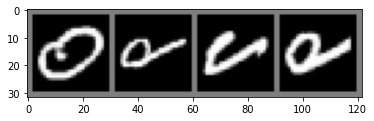

GroundTruth:  0 9 7 9


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [ ]:
um=[16,18,20,22,24,26,28,30,32,35,37,39,41,43,45]
ind=1
for i in range(qtd_fotos[2]):
      img = read_image(base_path+"2/IMG-20220922-WA00"+str(63+i)+".jpeg")
      write_jpeg(img,base_path+ha_arrumar+"2"+str(i)+".jpeg")


KeyError: ignored

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
res=[0,0,0,0,0,0,0,0,0,0]
acerto=[0,0,0,0,0,0,0,0,0,0]
acu=[0,0,0,0,0,0,0,0,0,0]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range(len(labels)):
          res[predicted[i].item()]+=1
          acerto[labels[i]]+=(predicted[i].item() == labels[i].item())
        correct += (predicted == labels).sum().item()
print(res,acerto)
for i in range(10):
  acu[i]=acerto[i]/res[i]
print(acu)
print(f'Accuracy of the network on the 10000 test images: {(correct / total)}')

[4003, 3982, 3977, 3979, 3956, 4035, 4008, 4047, 4002, 4011] [3980, 3978, 3953, 3955, 3939, 3981, 3981, 3990, 3967, 3953]
[0.9942543092680489, 0.9989954796584631, 0.993965300477747, 0.9939683337521991, 0.9957027300303337, 0.9866171003717472, 0.9932634730538922, 0.9859154929577465, 0.9912543728135932, 0.9855397656444776]
Accuracy of the network on the 10000 test images: 0.991925


In [ ]:
#Resize Banco
resize(0,9,True)
resize(0,9,False)

In [ ]:
#Fazendo a matriz com acertos e respostas para escolher a melhor
maior=0
treino_x=[]
for t in range(124,206,5):
  con=t
  to_black(0,9,True)
  for i in range(0,10):
    for j in range(qtd_fotos[treino[:6]][i]):
      image=Image.open(base_path+treino+arrumado+str(i)+str(j+1)+".jpg")
      val=transform(image)
      outputs=net(val)
      _, prediced = torch.max(outputs.data, 1)
      linha=[]
      for k in range(10):
        linha.append(predicted.item())
      linha.append(i)
      treino_x.append(linha)
treino_x

KeyboardInterrupt: ignored

In [ ]:
maior=0
treino_x=[]
maior=[0,0,0,0,0,0,0,0,0,0]
for t in range(124,206,5):
  con=t
  to_black(0,9,False)
  acertos=[0,0,0,0,0,0,0,0,0,0]
  resposta=[0,0,0,0,0,0,0,0,0,0]
  for i in range(0,10):
    for j in range(qtd_fotos[teste[:6]][i]):
      image=Image.open(base_path+teste+arrumado+str(i)+str(j+1)+".jpg")
      val=transform(image)
      outputs=net(val)
      _, prediced = torch.max(outputs.data, 1)
      acertos[i]+=(prediced.item()==i)
      resposta[prediced.item()]+=1
  print(acertos,resposta)
  for i in range(10):
    
    maior[i]=max(maior[i],acertos[i]/max(resposta[i],1))
print(maior)

[5, 4, 0, 1, 13, 1, 0, 1, 14, 5] [8, 8, 22, 6, 14, 40, 4, 15, 58, 7]
[6, 5, 0, 1, 16, 0, 0, 3, 14, 7] [10, 8, 26, 7, 17, 38, 3, 15, 47, 11]
[7, 5, 0, 1, 16, 1, 0, 3, 14, 8] [11, 9, 24, 7, 17, 40, 3, 17, 44, 10]
[7, 6, 0, 0, 15, 1, 0, 3, 14, 6] [12, 10, 26, 4, 16, 45, 2, 17, 42, 8]
[7, 5, 0, 1, 19, 0, 0, 4, 13, 5] [10, 9, 25, 5, 21, 47, 3, 17, 37, 8]
[5, 5, 1, 0, 16, 0, 0, 6, 14, 6] [8, 11, 25, 5, 17, 50, 2, 17, 36, 11]
[9, 8, 1, 0, 16, 0, 1, 5, 11, 6] [12, 15, 24, 8, 17, 48, 3, 19, 27, 9]
[9, 13, 1, 1, 16, 0, 2, 8, 9, 3] [13, 24, 19, 8, 18, 43, 3, 23, 25, 6]
[9, 13, 3, 1, 15, 0, 2, 7, 9, 3] [14, 30, 22, 5, 18, 40, 3, 21, 25, 4]
[7, 12, 4, 1, 14, 0, 0, 9, 5, 2] [9, 37, 23, 7, 18, 37, 1, 27, 18, 5]
[7, 13, 2, 0, 12, 0, 0, 10, 4, 1] [8, 54, 22, 8, 16, 32, 0, 27, 12, 3]
[6, 13, 3, 1, 8, 1, 0, 12, 4, 0] [6, 73, 17, 11, 11, 24, 0, 24, 12, 4]
[3, 14, 3, 1, 9, 1, 0, 9, 1, 1] [4, 87, 14, 7, 10, 24, 1, 24, 7, 4]
[2, 13, 2, 1, 9, 0, 0, 10, 1, 0] [2, 103, 16, 7, 9, 15, 0, 25, 3, 2]
[1, 13, 2, 0, 3

In [ ]:
17*182

3094

In [ ]:
con=208
to_black(0,0,False)

60
0.010925786835421234


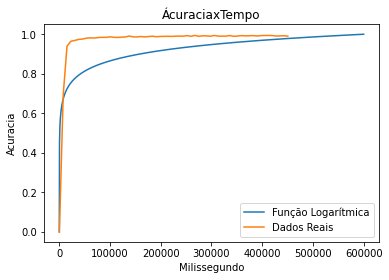

In [ ]:

Y=np.array(acuracias[:])
X=np.array(milissegundos[:])
print(X.size)
def logr(x):
  res=[]
  for i in x:
    res.append(math.log(i,600000))
  return res
Hx = np.linspace(1,600000,1500)
Hy = logr(Hx)
plt.title("ÁcuraciaxTempo")
plt.plot(Hx,Hy)
plt.plot(Y,X)
plt.legend(["Função Logarítmica","Dados Reais"])
plt.xlabel("Milissegundo")
plt.ylabel("Acuracia")
EQM=0
for i in range(len(acuracias)):
  EQM+=((logr([acuracias[i]])[0])-milissegundos[i])**2
print(EQM/X.size)

In [ ]:
Y=np.array(acuracias[:])
X=np.array(milissegundos[:])

def logr(x):
  res=[]
  for i in x:
    res.append(math.log(i,600000))
  return res
def sqrtr(x):
  res=[]
  for i in x:
    res.append(math.log(i,600000))
  return res
Hx = np.linspace(1,600000,1500)
Hy = logr(Hx)
plt.title("ÁcuraciaxTempo")
plt.plot(Hx,Hy)
plt.plot(Y,X)
plt.legend(["Função Logarítmica","Dados Reais"])
plt.xlabel("Milissegundo")
plt.ylabel("Acuracia")
EQM=0
for i in range(len(acuracias)):
  EQM+=(logr([acuracias[i]])[0]-milissegundos[i])**2
print(EQM/X.size)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dados_escalados=scaler.fit_transform(treino)
modelo=KMeans(n_clusters=17)
modelo.fit(dados_escalados)